# Izhikevich モデル
## Izhikevich モデルの定義
**Izhikevich モデル** (または**Simple model**)は([Izhikevich, 2003](https://www.izhikevich.org/publications/spikes.htm))で考案されたモデルである．HHモデルのような生理学的な知見に基づいたモデルは実際のニューロンの発火特性をよく再現できるが，式が複雑化するため，数学的な解析が難しく，計算量が増えるために大規模なシミュレーションも困難となる[^hh]．そこで，生理学的な正しさには目をつぶり，生体内でのニューロンの発火特性を再現するモデルが求められた．その特徴を持つのがIzhikevich モデルである (以下ではIzモデルと表記する)．Izモデルは 2変数しかない[^ber]簡素な微分方程式だが, 様々なニューロンの活動を模倣することができる．定式化には主に2種類ある．まず，([Izhikevich, 2003](https://www.izhikevich.org/publications/spikes.htm))で提案されたのが次式である．

$$
\begin{align}
\frac{dv(t)}{dt}&=0.04v(t)^2 + 5v(t)+140-u(t)+I(t) \\
\frac{du(t)}{dt}&=a(bv(t)-u(t))
\end{align} 
$$

ここで，$v$と$u$が変数であり, $v$は膜電位(membrane potential;単位はmV), $u$は回復電流(recovery current; 単位はpA)[^rec]である．また，$a$は回復時定数(recovery time constant; 単位はms$^{-1}$)の逆数 (これが大きいと$u$が元に戻る時間が短くなる), $b$は$u$の$v$に対する感受性(共鳴度合い,  resonance; 単位はpA/mV)である．

この式は簡便だが，生理学的な意味づけが分かりにくい．改善された式として["Dynamical Systems in Neuroscience" (Izhikevich, 2007)](https://mitpress.mit.edu/books/dynamical-systems-neuroscience)のChapter 8で紹介されているのが次式である．

$$
\begin{align}
C\frac{dv(t)}{dt}&=k\left(v(t)-v_r\right)\left(v(t)-v_t\right)-u(t)+I(t) \\
\frac{du(t)}{dt}&=a\left\{b\left(v(t)-v_{r}\right)-u(t)\right\}
\end{align} 
$$

ここで，$C$は膜容量(membrane capacitance; 単位はpF), $v_r$は静止膜電位(resting membrane potential; 単位はmV), $v_t$は閾値電位(instantaneous threshold potential; 単位はmV), $k$はニューロンのゲインに関わる定数で，小さいと発火しやすくなる (単位はpA/mV)．以後はこちらの式を用いる．

Izモデルの**閾値の取り扱い**はLIFモデルと異なり，HHモデルに近い．LIFモデルでは閾値を超えた時に膜電位をピーク電位まで上昇させ (この過程は無くてもよい)，続いて膜電位をリセットする．Izモデルの閾値は$v_t$だが, 膜電位のリセットは閾値を超えたかで判断せず，膜電位$v$がピーク電位$v_{\text{peak}}$になったとき（または超えた時）に行う．そのためIzモデルの実際の閾値は膜電位の挙動が変化する(発火状態に移行する)，つまり分岐(bifurcation) が生じる点であり，パラメータの閾値$v_t$との間には差異がある．

さて，膜電位がピーク電位$v_{\text{peak}}$に達したとき (すなわち `if` $v \geq v_{\text{peak}}$)，$u, v$を次のようにリセットする[^burst]．

$$
\begin{align} 
u&\leftarrow u+d\\
v&\leftarrow v_{\text{reset}}
\end{align}
$$

とする．ただし, $v_{\text{reset}}$は過分極を考慮して静止膜電位$v_r$よりも小さい値とする．また，$d$はスパイク発火中に活性化される正味の外向き電流の合計を表し，発火後の膜電位の挙動に影響する (単位はpA)．

以上を踏まえて, シミュレーションを行う．まず，必要なパッケージを読み込む．

[^hh]: これに関しては必ずしも正しくない．計算機の発達によりHHモデルで大きなモデルをシミュレーションすることも可能である．
[^ber]: 数値計算をする上では簡易的だが，if文が入るために解析をするのは難しくなる．([Bernardo, et al., 2008](https://www.springer.com/gp/book/9781846280399))を読むといいらしい．
[^rec]: ここでの「回復」というのは脱分極した後の膜電位が静止膜電位へと戻る，という意味である (対義語はactivationで膜電位の上昇を意味する)．
$u$は$v$の導関数において$v$の上昇を抑制するように$-u$で入っているため，$u$としてはK$^+$チャネル電流やNa$^+$チャネルの不活性化動態などが考えられる．
[^burst]: バースト発火(bursting)の挙動を表現するためには，速い回復変数(fast recovery variable)と遅い回復変数(slow recovery variable)の2つが必要となる(従って膜電位も合わせて全部で3変数必要)．一方で，IzモデルではLIFモデルのようなif文によるリセットを用いているため，速い回復変数が必要なく，遅い回復変数$u$のみでバースト発火を表現できる．


In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using PyPlot

変更しない定数を保持する`struct`の`IZParameter`と，変数を保持する`mutable struct`の`IZ`を作成する．2つの定式化でパラメータの値が異なるので注意すること．

In [2]:
@kwdef struct IZParameter{FT}
    C::FT = 100  # 膜容量 (pF)
    a::FT = 0.03 # 回復時定数の逆数 (1/ms)
    b::FT = -2 # u の v に対する共鳴度合い (pA/mV)
    d::FT = 100 # 発火で活性化される正味の外向き電流 (pA)
    k::FT = 0.7 # ゲイン (pA/mV)
    vthr::FT = -40 # 閾値電位 (mV)
    vrest::FT = -60 # 静止膜電位 (mV)
    vreset::FT = -50 # リセット電位 (mV)
    vpeak::FT = 35 #　ピーク電位 (mV)
end

@kwdef mutable struct IZ{FT}
    param::IZParameter = IZParameter{FT}()
    N::UInt32
    v::Vector{FT} = fill(param.vrest, N)
    u::Vector{FT} = zeros(N)
    fire::Vector{Bool} = zeros(Bool, N)
end

次に変数を更新する関数`update!`を書く．LIFの場合と異なり，`v[i] >= vpeak`であることに注意する (`v[i] >= vthr`ではない)．

In [3]:
function update!(variable::IZ, param::IZParameter, Ie::Vector, dt)
    @unpack N, v, u, fire = variable
    @unpack C, a, b, d, k, vthr, vrest, vreset, vpeak = param
    @inbounds for i = 1:N
        v[i] += dt/C * (k*(v[i]-vrest)*(v[i]-vthr) - u[i] + Ie[i])
        u[i] += dt * (a * (b * (v[i]-vrest) - u[i]))
    end
    @inbounds for i = 1:N
        fire[i] = v[i] >= vpeak
        v[i] = ifelse(fire[i], vreset, v[i])
        u[i] += ifelse(fire[i], d, 0)
    end
end;

## Izhikevich モデルのシミュレーションの実行
いくつかの定数を設定してシミュレーションを実行する．

In [4]:
T = 450 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
Ie = repeat(150f0 * ((t .> 50) - (t .> 200)) + 300f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr, uarr = zeros(Float32, nt, N), zeros(Float32, nt, N)

# modelの定義
neurons = IZ{Float32}(N=N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, Ie[i, :], dt)
    varr[i, :], uarr[i, :] = neurons.v, neurons.u
end

  0.112818 seconds (741.86 k allocations: 22.753 MiB, 58.96% compilation time)


`Plots`を読み込み，膜電位`v`, 回復変数`u`, 入力電流`I`を描画する．

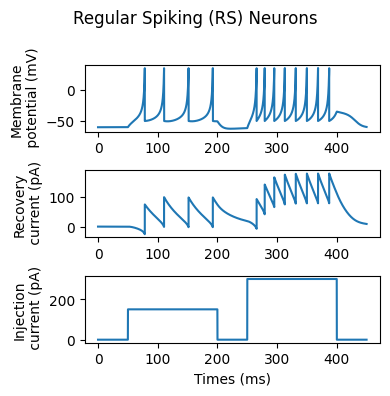

In [5]:
figure(figsize=(4, 4))
suptitle("Regular Spiking (RS) Neurons")
subplot(3,1,1); plot(t, varr[:, 1]); ylabel("Membrane\n potential (mV)")
subplot(3,1,2); plot(t, uarr[:, 1]); ylabel("Recovery\n current (pA)")
subplot(3,1,3); plot(t, Ie[:, 1]); ylabel("Injection\n current (pA)"); xlabel("Times (ms)")
tight_layout(rect=[0,0,1,0.96])

## 様々な発火パターンのシミュレーション
次に様々な発火パターンを模倣するようにIzモデルの定数を変化させてみよう．Intrinsically Bursting (IB)ニューロンとChattering (CH) ニューロン(または fast rhythmic bursting (FRB) ニューロン)のシミュレーションを行う．基本的には定数を変えるだけである．

```{note}
本書で用いている式における発火パターンに対するパラメータは([Izhikevich, 2003](https://www.izhikevich.org/publications/spikes.htm))では得られないが，["Dynamical Systems in Neuroscience" (Izhikevich, 2007)](https://mitpress.mit.edu/books/dynamical-systems-neuroscience)には記載がある．他の発火パターンに関してはこの本を参照のこと．
```

In [6]:
# 記録用
varr_ib, varr_ch = zeros(Float32, nt, N), zeros(Float32, nt, N)
Ie = repeat(500f0 * ((t .> 50) - (t .> 200)) + 700f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# IB neurons
neurons_ib = IZ{Float32}(N=N, 
    param=IZParameter{Float32}(C = 150, a = 0.01, b = 5, k =1.2, d = 130, vrest = -75, vreset = -56, vthr = -45, vpeak = 50))

# CH neurons
neurons_ch = IZ{Float32}(N=N, 
    param=IZParameter{Float32}(C = 50, a = 0.03, b = 1, k =1.5, d = 150, vrest = -60, vreset = -40, vthr = -40, vpeak = 35))

# simulation
@time for i = 1:nt
    update!(neurons_ib, neurons_ib.param, Ie[i, :], dt)
    update!(neurons_ch, neurons_ch.param, Ie[i, :], dt)
    varr_ib[i, :], varr_ch[i, :] = neurons_ib.v, neurons_ch.v
end

  0.061914 seconds (759.89 k allocations: 19.148 MiB)


これまでと異なり，モデルの定義時に`param`を設定していることに注意しよう．最後に膜電位変化を描画する．

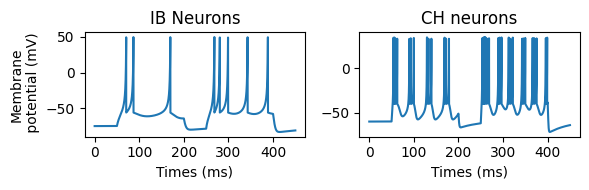

In [7]:
figure(figsize=(6, 2))
subplot(1,2,1); plot(t, varr_ib[:, 1]); title("IB Neurons"); ylabel("Membrane\n potential (mV)");  xlabel("Times (ms)")
subplot(1,2,2); plot(t, varr_ch[:, 1]); title("CH neurons"); xlabel("Times (ms)")
tight_layout()

## ランダムネットワークのシミュレーション
1000個のIzニューロン(興奮性800個, 抑制性200個)によるランダムネットワークのシミュレーションを行う．これは([Izhikevich, 2003](https://www.izhikevich.org/publications/spikes.htm))においてMATLABコードが示されており，それをJuliaに移植したものである．このシミュレーションではRS(regular spiking)ニューロンを興奮性細胞，FS(fast spiking)ニューロンを抑制性細胞のモデルとして用いている．

In [8]:
# Excitatory neurons, Inhibitory neurons
Ne, Ni = 800, 200;
re, ri = rand(Ne,1), rand(Ni,1)
a = [0.02ones(Ne,1); 0.02 .+ 0.08ri]
b = [0.2ones(Ne,1); 0.25 .- 0.05ri]
c = [-65 .+ 15re.^2; -65ones(Ni,1)]
d = [8 .- 6re.^2; 2ones(Ni,1)]
S = [0.5rand(Ne+Ni,Ne) -rand(Ne+Ni,Ni)] # synaptic weight
v = -65ones(Ne+Ni,1)   # Initial values of v
u = b .* v              # Initial values of u
firings = []            # spike timings

for t=1:1000 # simulation of 1000 ms
    Ie = [5randn(Ne,1); 2randn(Ni,1)] # thalamic input
    fired = findall(v[:, 1] .>= 30) # indices of spikes
    firings = t==1 ? [t .+ 0*fired fired] : [firings; [t .+ 0*fired fired]]
    v[fired] = c[fired]
    u[fired] += d[fired]
    Ie += sum(S[:,fired], dims=2)
    v += 0.5(0.04v.^2 + 5v .+140 - u + Ie) # step 0.5 ms for numerical stability
    v += 0.5(0.04v.^2 + 5v .+140 - u + Ie) 
    u += a .* (b .* v - u)
end

膜電位の更新の際，`v`を2回に分けて更新しているが，これは数値的な安定性を高めるためである．計算量は上がるが，前述したモデルにおいても同様の処理を行う実装もある．

シミュレーションの実行後，ネットワークを構成するニューロンの発火を描画する．これを**ラスタープロット** (raster plot)という．この図は横軸が時間，縦軸がニューロンの番号となっており，各ニューロンが発火したことを点で表している．

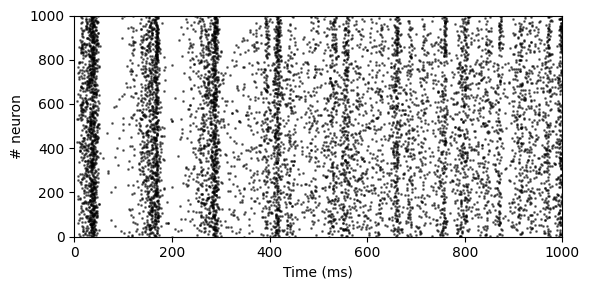

In [9]:
figure(figsize=(6, 3))
scatter(firings[:,1], firings[:,2], c="k", s=1, alpha=0.5)
xlabel("Time (ms)"); ylabel("# neuron"); xlim(0, 1000); ylim(0, 1000)
tight_layout()

初めの400msぐらいまでは100msごとに約10Hzの$\alpha$波が見られ，800ms付近には約40Hzの$\gamma$波が見られる．